Michał, Z., William, C., Karl, P., Oier, M., Chelsea, F., & Sergey, L. (2024). [Robotic Control via Embodied Chain-of-Thought Reasoning](https://arxiv.org/abs/2407.08693). arXiv preprint arXiv:2407.08693.

**Abstract**
<!-- A key limitation of learned robot control policies is their inability to generalize outside their training data. Recent works on vision-language-action models (VLAs) have shown that the use of large, internet pre-trained vision-language models as the backbone of learned robot policies can substantially improve their robustness and generalization ability. Yet, one of the most exciting capabilities of large vision-language models in other domains is their ability to reason iteratively through complex problems. Can that same capability be brought into robotics to allow policies to improve performance by reasoning about a given task before acting? Naive use of "chain-of-thought" (CoT) style prompting is significantly less effective with standard VLAs because of the relatively simple training examples that are available to them. Additionally, purely semantic reasoning about sub-tasks, as is common in regular CoT, is insufficient for robot policies that need to ground their reasoning in sensory observations and the robot state. To this end, we introduce Embodied Chain-of-Thought Reasoning (ECoT) for VLAs, in which we train VLAs to perform multiple steps of reasoning about plans, sub-tasks, motions, and visually grounded features like object bounding boxes and end effector positions, before predicting the robot action. We design a scalable pipeline for generating synthetic training data for ECoT on large robot datasets. We demonstrate, that ECoT increases the absolute success rate of OpenVLA, the current strongest open-source VLA policy, by 28% across challenging generalization tasks, without any additional robot training data. Additionally, ECoT makes it easier for humans to interpret a policy's failures and correct its behavior using natural language. -->
学习机器人控制策略的一个关键限制是它们无法在训练数据之外进行泛化. 最近关于视觉-语言-动作模型 (VLAs) 的研究表明, 使用大型、互联网预训练的视觉语言模型作为学习机器人策略的 backbone 可以大幅提高其鲁棒性和泛化能力. 然而, 大型视觉语言模型在其他领域最令人兴奋的能力之一是它们能够迭代推理复杂问题. 能否将同样的能力引入机器人, 通过在行动前推理给定任务, 让策略提高性能? 对于标准 VLAs 而言, 单纯使用"思路链"(CoT)风格提示的效果会差很多, 因为它们可用的训练示例相对简单. 此外, 对于(需要以感官观察和机器人状态为基础进行推理的)机器人策略而言, 关于子任务的纯语义推理(如常规 CoT 中常见的那样)是不够的. 为此, 我们为 VLAs 引入具身思维链推理 (ECoT), 在预测机器人动作之前, 我们训练 VLAs 对规划、子任务、运动和视觉基础特征(如物体边界框和末端执行器位置)执行多步推理. 我们设计了一个可扩展的流水线, 用于在大型机器人数据集上为 ECoT 生成合成训练数据. 我们证明, ECoT 在具有挑战性的泛化任务上, 将 OpenVLA (目前最强大的开源 VLA 策略)的绝对成功率提高了 28%, 无需任何额外的机器人训练数据. 此外, ECoT 使人类更容易解释策略的失败, 并使用自然语言修正其行为.

# Introduction
<!-- Robotic policies trained end-to-end for outputting raw low-level actions in response to sensory observations provide a powerful and appealing learning-based approach to robotic control, obviating the need for complex sensing and control stacks, and processing complex observations into dexterous low-level controls [1, 2, 3]. However, this kind of "reactive" control is not necessarily the best choice in settings that demand broad generalization, such as novel scenes or interactions with unfamiliar objects. In such situations, a person might need to think more carefully – if they were asked to put fruit on one plate and vegetables on another, they might first try to figure out which objects are fruits and which are vegetables, rather than simply performing a learned skill from "muscle memory." In the same way, we would like our robotic policies to both perform well-practiced end-to-end control, and to "reason through" novel situations before grounding their commands into actions. Such reasoning might include identifying and locating task relevant objects, producing a plan to accomplish a task, and translating sub-tasks and observations into movements. -->
端到端训练的机器人策略根据感知观察输出原始的下层动作, 为机器人控制提供了一种强大且有吸引力的基于学习的方法, 无需复杂的感知和控制栈, 并将复杂的观察处理为灵巧的下层控制 [1, 2, 3]。然而, 这种"反应式"控制在需要广泛泛化的配置中, 不一定是最好的选择, 例如新场景或与不熟悉物体的交互。在这种情况下, 一个人可能需要更仔细地思考——如果要求他们把水果放在一个盘子里, 把蔬菜放在另一个盘子里, 他们可能首先试图弄清楚哪些物体是水果, 哪些是蔬菜, 而不是简单地根据"肌肉记忆"执行所学的技能。同样, 我们希望我们的机器人策略既能执行经过良好练习的端到端控制, 又能在将命令付诸行动之前, "推理"新情况。这种推理可能包括识别和定位与任务相关的对象, 制定一个计划以完成任务, 以及将子任务和观察转化为运动。

<!-- Vision-language-action models (VLAs) – pre-trained vision-language models (VLMs) fine-tuned to produce robot actions – have gained popularity as an approach for leveraging the diversity of Internet data captured within large foundation models [4] in a simple and scalable policy learning recipe. Despite achieving state-of-the-art performance across a wide range of tasks and robot embodiments [5, 6, 7], VLAs typically learn a direct mapping from observations to actions without any intermediate reasoning. However, there have been many recent works exploring how language models (which serve as the backbone of VLAs) can be prompted to textually "think step-by-step" about a given task. Such chain-of-thought reasoning (CoT) [8] significantly improves their performance on complex reasoning tasks and is now de-facto a standard practice in language modeling [9]. -->
视觉-语言-动作模型 (VLAs) —— 微调预训练的视觉-语言模型 (VLMs) 以生成机器人动作 —— 作为一种利用大型基础模型 [4] 中捕获的互联网数据多样性的方法, 在简单且可扩展的策略学习方法中广受欢迎。尽管在广泛的任务和机器人具身中实现了最先进的性能 [5、6、7], 但 VLAs 通常学习从观察到的动作的直接映射, 而无任何中间推理。然而, 最近有许多研究探索如何提示语言模型(作为 VLAs 的 backbone)以文本形式"逐步思考"给定任务。这种思路链推理 (CoT) [8] 显著提高了它们在复杂推理任务上的表现, 现在已成为语言建模领域中的一种事实上的标准做法 [9]。

<!-- We thus hypothesize that we can similarly boost VLA performance by training them to **textually reason** about their plan, environment, and motions, thereby allowing them to produce more accurate and robust robot actions. However, simply applying the CoT techniques from language modeling to the robotics domain faces several challenges. For one, current VLAs build on relatively small, open-source VLMs that cannot match closed models in their ability to perform meaningful reasoning when simply prompted to think step-by-step [8]. Additionally, the most common CoT reasoning in language models, breaking tasks into sub-tasks, albeit helpful, is insufficient for reasoning about robotic tasks. The VLA policy needs to ground its plans and reasoning in its *observations* of the environment and robot state. Only then can the reasoning direct the agent's attention toward fine-grained spatial or semantic perceptual features that are key for solving robot manipulation tasks. Put simply, we need VLAs to not only "think carefully", but also "look carefully." -->
因此, 我们假设我们可以通过训练 VLA 对其规划、环境和动作进行**文本推理**来类似地提高 VLA 的性能, 从而使它们能够生成更准确、更鲁棒的机器人动作。然而, 仅将语言建模中的 CoT 技术应用于机器人领域面临一些挑战。首先, 当前的 VLAs 建立在相对较小的开源 VLMs 上, 这些 VLMs 在仅被提示逐步思考时, 在执行有意义的推理的能力方面无法与封闭模型相媲美 [8]。此外, 语言模型中最常见的 CoT 推理, 将任务分解为子任务, 虽然有帮助, 但不足以推理机器人任务。VLA 策略需要将其计划和推理建立在其对环境和机器人状态的*观察*上。只有这样, 推理才能将智能体的注意力引向细粒度的空间或语义感知特征, 它们是解决机器人操作任务的关键。简而言之, 我们不仅需要 VLAs "仔细思考", 还需要"仔细观察"。

<!-- To this end, we introduce **Embodied Chain-of-Thought Reasoning** (**ECoT**) for VLA policies. In contrast to prior VLAs, embodied chain-of-thought policies perform multiple steps of textual reasoning before predicting the next robot action (see Fig. 1, right). In contrast to existing CoT reasoning approaches for language models, they interleave semantic-level reasoning about sub-tasks with "embodied" reasoning tasks that require the policy to pay attention to its multi-modal inputs, from predicting bounding boxes of objects in the scene to reasoning about low-level movement primitives that need to be executed based on the current robot state. To enable the relatively weak LLM backbones of open-source VLAs to perform such reasoning effectively, we design a scalable pipeline for synthetically generating embodied CoT training data for large robot datasets. Concretely, we use powerful pre-trained open-vocabulary object detectors and large language models to generate the reasoning supervision for our policies. -->
为此, 我们为 VLA 策略提出**具身思维链推理** (**ECoT**)。与之前的 VLAs 相比, 具身思维链策略在预测下一个机器人动作之前, 执行多步文本推理(见[图1](#fig.1) 右)。与现有的语言模型 CoT 推理方法相比, 它们将子任务的语义级推理与"具身"推理任务交织在一起, 这些任务需要策略注意其多模态输入, 从(预测场景中对象的边界框)到(推理下层运动原语, 需要基于当前机器人状态来执行这些运动原语)。为了使开源 VLAs 相对较弱的 LLM backbones 能够有效地执行这种推理, 我们设计了一个可扩展的流水线, 用于(为大型机器人数据集)合成生成具身 CoT 训练数据。具体而言, 我们使用强大的预训练开放词汇表对象检测器和大语言模型, 为我们的策略生成推理指导。

<span id='fig.1'></span>
todo: 图1
<!-- Figure 1: We propose embodied chain-of-thought reasoning for vision-language-action models (VLAs): prior VLAs directly predict the next robot action given the task (left), we instead train VLA policies to think "step-by-step" (right). Crucially, reasoning through low-level visual and embodied features like object bounding boxes and gripper positions in addition to purely textual CoT elements like sub-task plans, forces the policy to "think carefully" and "look carefully" before acting. Embodied CoT reasoning increases the absolute success rate of state-of-the-art OpenVLA policies [7] by 28% in challenging generalization tasks. -->
图1: 我们提出了视觉-语言-动作模型 (VLAs) 的具身思维链推理: 先前的 VLAs 直接预测给定任务的下一个机器人动作(左), 我们训练 VLA 策略以"逐步"思考(右)。至关重要的是, 除了纯文本 CoT 元素如子任务规划)之外, 通过下层视觉和具身特征(如物体边界框和夹具位置)进行推理, 迫使策略在行动前"仔细思考"和"仔细观察"。具身 CoT 推理将最先进的 OpenVLA 策略 [7] 在具有挑战性的泛化任务中的绝对成功率提高了 28%。

<!-- Our experiments show that by training state-of-the-art VLAs to perform multiple steps of reasoning before action prediction, we can substantially boost their ability to perform challenging generalization tasks. Our approach increases the absolute success rate of OpenVLA [7], the current best-performing open-source VLA policy, by 28% across a suite of robot manipulation tasks that involve generalization to new objects, scenes, viewpoints, and instructions without any additional robot training data. Beyond raw performance improvements, our experiments show that training VLAs with embodied CoT makes policy failures more interpretable and allows humans to easily correct policy behavior by modifying faulty reasoning chains via natural language feedback. -->
我们的实验表明, 通过训练最先进的 VLAs, 在动作预测之前, 执行多步推理, 我们可以大幅提升它们执行具有挑战性的泛化任务的能力。我们的方法将当前表现最佳的开源 VLA 策略 OpenVLA [7] 的绝对成功率在一系列机器人操作任务中提高了 28%, 这些任务涉及对新对象、场景、视点和指令的泛化, 而无需任何额外的机器人训练数据。除了原始性能改进之外, 我们的实验表明, 使用具身 CoT 训练 VLAs 使策略失败更容易解释, 并允许人类通过自然语言反馈修改错误的推理链, 进而轻松地修正策略行为。

# Related Work
<!-- **Scaling robot learning**. A long-standing goal of robot learning is to train policies that can generalize to a wide range of unstructured real-world environments. Towards this goal, recent works have explored training "generalist robot policies" [10, 11, 12, 13, 14, 15, 16, 17] on diverse robot datasets [18, 19, 10, 20, 21, 22, 23, 24, 13, 14, 25, 15, 26, 6]. As a result of their diverse robot training datasets, many of these policies can be prompted in natural language to solve various manipulation tasks, and some generalist policies can even control multiple robot embodiments [16, 27, 6]. Importantly, these works demonstrate that training robot policies on large and diverse datasets is a promising approach towards improving policy robustness and generalization ability. -->
**扩展机器人学习**. 机器人学习的一个长期目标是训练可以泛化到各种非结构化现实世界环境的策略。为了实现这一目标, 最近的研究探索在多样化的机器人数据集 [18、19、10、20、21、22、23、24、13、14、25、15、26、6] 上训练"通用机器人策略" [10、11、12、13、14、15、16、17]。由于其多样化的机器人训练数据集, 这些策略中的一些可以用自然语言提示来解决各种操作任务, 一些通用策略甚至可以控制多种机器人实施例 [16、27、6]。重要的是, 这些研究表明, 在大型和多样化的数据集上训练机器人策略是一种提高策略稳健性和泛化能力的有前途的方法。

<!-- **Vision-language models for robot generalization**. In a push towards generalization far beyond what is observed in robot datasets, the recent development of strong, open-source vision-language models that learn visuo-linguistic representations [28, 29], generate images from text [30], or generate text in response to images and prompts [31, 32, 33, 34, 35] have resulted in a large number of works that explore the integration of such models into robot learning pipelines, e.g., to generate goals [36], to provide reward signals [37, 38, 39], or to learn visual state representations [40, 41, 42]. Since collection of the aforementioned large-scale robot datasets is challenging, using models pre-trained on Internet-scale data is an appealing alternate path towards robust robot policies that can act in a variety of unstructured real-world environments. Most relevant to our work are recent approaches for integrating pre-trained vision-language models into learned robot policies. While some works use strong structural priors in their policies to enable this integration [43, 44, 45], vision-language-action models (VLAs) have recently been proposed as a simple yet scalable alternative [5, 6, 7], achieving state-of-the-art performance for generalist robot policies [7] and showing impressive levels of generalization to new objects and scenes. However, existing VLAs do not sufficiently leverage some of the most appealing properties of the underlying language and vision-language models, specifically their ability to reason through the steps required to solve a given task. -->
**用于机器人泛化的视觉语言模型**. 为了推动(远超机器人数据集中观察范围的)泛化, 强大的开源视觉语言模型(这些模型学习视觉语言表征 [28, 29]、从文本生成图像 [30] 或根据图像和提示生成文本 [31, 32, 33, 34, 35])的最近发展催生了大量研究, 这些研究探索将这些模型集成到机器人学习流水线中, 例如生成目标 [36]、提供奖励信号 [37, 38, 39] 或学习视觉状态表征 [40, 41, 42]。由于上述大规模机器人数据集的收集具有挑战性, 使用在互联网规模数据上预训练的模型是实现(可在各种非结构化现实世界环境中发挥作用的)鲁棒机器人策略的有吸引力的替代途径。与我们的工作最相关的是最近(将预训练的视觉语言模型集成到学习机器人策略中的)方法。尽管一些工作在其策略中使用强大的结构先验来实现这种集成 [43, 44, 45], 但是视觉语言动作模型 (VLAs) 最近被提出作为一种简单但可扩展的替代方案 [5, 6, 7], 实现了通用机器人策略的最先进的性能 [7], 并展示出对新对象和场景的令人印象深刻的泛化水平。然而, 现有的 VLAs 没有充分利用潜在的语言和视觉语言模型的一些最吸引人的特性, 特别是它们<font color="red">**推理解决给定任务所需步骤**</font>的能力。

<!-- **Reasoning for language and control**. Such step-by-step reasoning is a key ingredient for the ability of large language models (LLMs) to solve a wide range of complex tasks. Prompting LLMs (directly [46] or with in-context examples [8]) to "think step-by-step" about the problem before formulating an answer can significantly improve their performance, with such chain-of-thought reasoning techniques becoming standard practice in language modeling and (vision-)language model training [9, 47]. A number of works have explored similar techniques in the context of high-level task planning for robotics [48, 49, 50, 51, 52, 53, 54, 55, 56]. These approaches use pre-trained or fine-tuned LLMs to decompose tasks into high-level sub-tasks, but rely on pre-trained low-level policies to execute them. However, we argue that (1) careful reasoning can be beneficial for both high-level sub-task reasoning *and* during low-level control and (2) all such levels of reasoning should be strongly grounded in visual observations of the scene and the agent’s state. Thus, in contrast to these prior works and language-only CoT, our approach trains a VLA policy to autoregressively generate CoTs (for high- and low-level reasoning) and actions given input instructions and observations, ensuring that both are firmly grounded in the agent’s environment. We empirically confirm that such a formulation is critical to effectively leveraging (V)LM reasoning capabilities for control. -->
**用于语言和控制的推理**. 这种逐步推理是大语言模型 (LLMs) 解决各种复杂任务的关键因素。提示 LLMs (直接 [46] 或使用上下文示例 [8]) 在创建答案之前"逐步思考"问题, 可以显著提高其性能, 这种思路链推理技术已成为语言建模和(视觉-)语言模型训练的标准做法 [9, 47]。许多研究在机器人的上层任务规划的背景下探索了相似的技术 [48, 49, 50, 51, 52, 53, 54, 55, 56]。这些方法使用预训练的或微调的 LLMs 将任务分解为上层子任务, 但依赖预训练的下层策略来执行它们。然而, 我们认为 (1) 谨慎的推理对上层子任务推理*和*低级控制都有益处, (2) 所有这些级别的推理都应该建立在场景和智能体状态的视觉观察的基础上。因此, 与这些先前的研究和纯语言 CoT 相比, 我们的方法训练 VLA 策略, 根据输入指令和观察自回归生成 CoT (用于上层和下层推理)和动作, 确保两者都牢牢扎根于智能体的环境中。我们通过经验证实, 这种表述对于有效利用 (V)LM 推理能力进行控制至关重要。

# Preliminaries: Vision-Language-Action Models
<!-- Our work leverages VLAs as the backbone for our embodied chain-of-thought policies. VLAs use a simple policy learning recipe: starting from a pre-trained vision-language model, they directly finetune the model to autoregressively predict the next robot action $a$ given the current image observation $I$ and task instruction $T$. To enable this, the continuous robot actions are typically converted to discrete action tokens $\mathcal{T}_a$ in the vocabulary of the vision-language model via a per-dimension action discretization scheme that assigns each continuous value to one of 256 bins [5, 7]. -->
我们的工作利用 VLAs 作为我们具身思路链策略的 backbone。VLAs 使用一种简单的策略学习方法: 从预训练的视觉-语言模型开始, 它们直接微调模型, 根据当前图像观察 $I$ 和任务指令 $T$, 自回归预测下一个机器人动作 $a$。为了实现这一点, 通过每个维度的动作离散化方案, 通常将连续的机器人动作转换为视觉-语言模型的词汇表中的离散动作词元 $\mathcal{T}_a$, 该方案将每个连续值分配到 256 个箱子中的一个 [5, 7]。

<!-- In this work, we use the recently released OpenVLA model [7] (see Fig. 2), since it achieves state-of-the-art performance and is fully open-source. The model builds on the Prismatic VLM [35] and consists of a fused visual encoder that combines pre-trained SigLIP [57] and/or DinoV2 [58] features and a Llama 2 7B [59] LLM backbone. During training, input images are encoded into visual token embeddings using the pre-trained vision encoders, the task instruction is mapped to task tokens using Llama 2’s text tokenizer, and the model is trained to map these inputs to the target action tokens. Next, we will discuss how we can improve upon this conventional VLA training recipe by enabling the VLA to reason through the task at hand before deciding which action to take. -->
在本研究中, 我们使用最近发布的 OpenVLA 模型 [7] (见[图2](#fig.2)), 因为它实现了最先进的性能并且完全开源。该模型基于 Prismatic VLM [35], 包含一个融合的视觉编码器, 它结合预训练的 SigLIP [57] 和/或 DinoV2 [58] 特征和 Llama 2 7B [59] LLM backbone。<font color="red">在训练期间, 使用预训练的视觉编码器, 将输入图像编码为视觉词元嵌入, 使用 Llama 2 的文本分词器, 将任务指令映射到任务词元, 并训练模型将这些输入映射到目标动作词元</font>。接下来, 我们将讨论在决定采取何种动作前, 通过使 VLA 能够推理手头的任务, 如何改进这种常规的 VLA 训练方法。

<span id='fig.2'></span>
todo: 图2
<!-- Figure 2: The OpenVLA model. Reproduced with permission from Kim et al. [7]. -->
图2: OpenVLA 模型。经 Kim et al. [7] 许可转载。

# Embodied Chain-of-Thought Reasoning for Visuomotor Policies
<!-- In this section, we discuss our approach for training VLAs to perform embodied chain-of-thought reasoning about plans, sub-tasks, motions, and visual features before predicting the next robot action (see [Fig. 1](#fig.1)). Unlike many proprietary large language models, the relatively small LLM backbones used in current VLAs struggle to perform involved reasoning when simply prompted to think step-by-step [8]. Instead, we propose to explicitly train VLA models to perform embodied CoT reasoning. Concretely, we label data from existing robot datasets post-hoc with reasoning chains filled with features extracted from various pre-trained models and use the resulting dataset of observation-reasoning-action tuples for training. In practice, we ensure that all elements of the generated reasoning data can be represented as strings, such that we can use the Llama 2 text tokenizer to translate them into reasoning tokens. Then, we can simply train the VLA to autoregressively predict these tokens, directly followed by action tokens. -->
在本节中, 我们讨论在预测下一个机器人动作前, 训练 VLAs 以执行具身思维链推理规划、子任务、运动和视觉特征的方法(见[图 1](#fig.1))。与许多专有的大语言模型不同, (当前 VLAs 中使用的相对较小的) LLM backbones 在简单地被提示以逐步思考时, 难以执行复杂的推理 [8]。相反，我们建议明确地训练 VLA 模型以执行具体 CoT 推理。具体而言, 我们用被(从各种预训练模型中提取的)特征填充的推理链, 对现有机器人数据集中的数据进行事后标注, 并使用生成的观察-推理-动作元组数据集进行训练。在实践中, 我们确保生成的推理数据的所有元素都可以表示为字符串, 这样我们可以使用 Llama 2 文本分词器, 将它们转换为推理词元。然后, 我们可以简单地训练 VLA 来自回归预测这些词元, 然后直接预测动作词元。

<!-- While this approach is conceptually simple, its implementation requires answering multiple key questions: (1) Which reasoning steps are suitable for guiding policies in solving embodied robot manipulation tasks ([Fig. 3](#fig.3))? (2) How can we generate training data for these reasoning steps at scale on existing robot datasets (Section [4.2](#Generating-Embodied-Chain-of-Thought-Data-at-Scale))? Another practical consideration arises *after* training, while using ECoT policies for robot control: carefully reasoning through each action can significantly slow down policy inference. We discuss solutions to these problems in the following sections. -->
尽管这种方法在概念上很简单, 但其实施需要回答多个关键问题: (1) 哪些推理步骤适合指导解决具身机器人操作任务的策略([图3](#fig.3))? (2) 我们如何在现有机器人数据集上大规模地生成这些推理步骤的训练数据(第 [4.2](#Generating-Embodied-Chain-of-Thought-Data-at-Scale) 节)? 尽管使用 ECoT 策略进行机器人控制, 训练*后*出现了另一个现实考虑: 仔细推理每个动作会显著地减慢策略推理速度。我们将在以下章节中讨论这些问题的解决方案。

<span id='fig.3'></span>
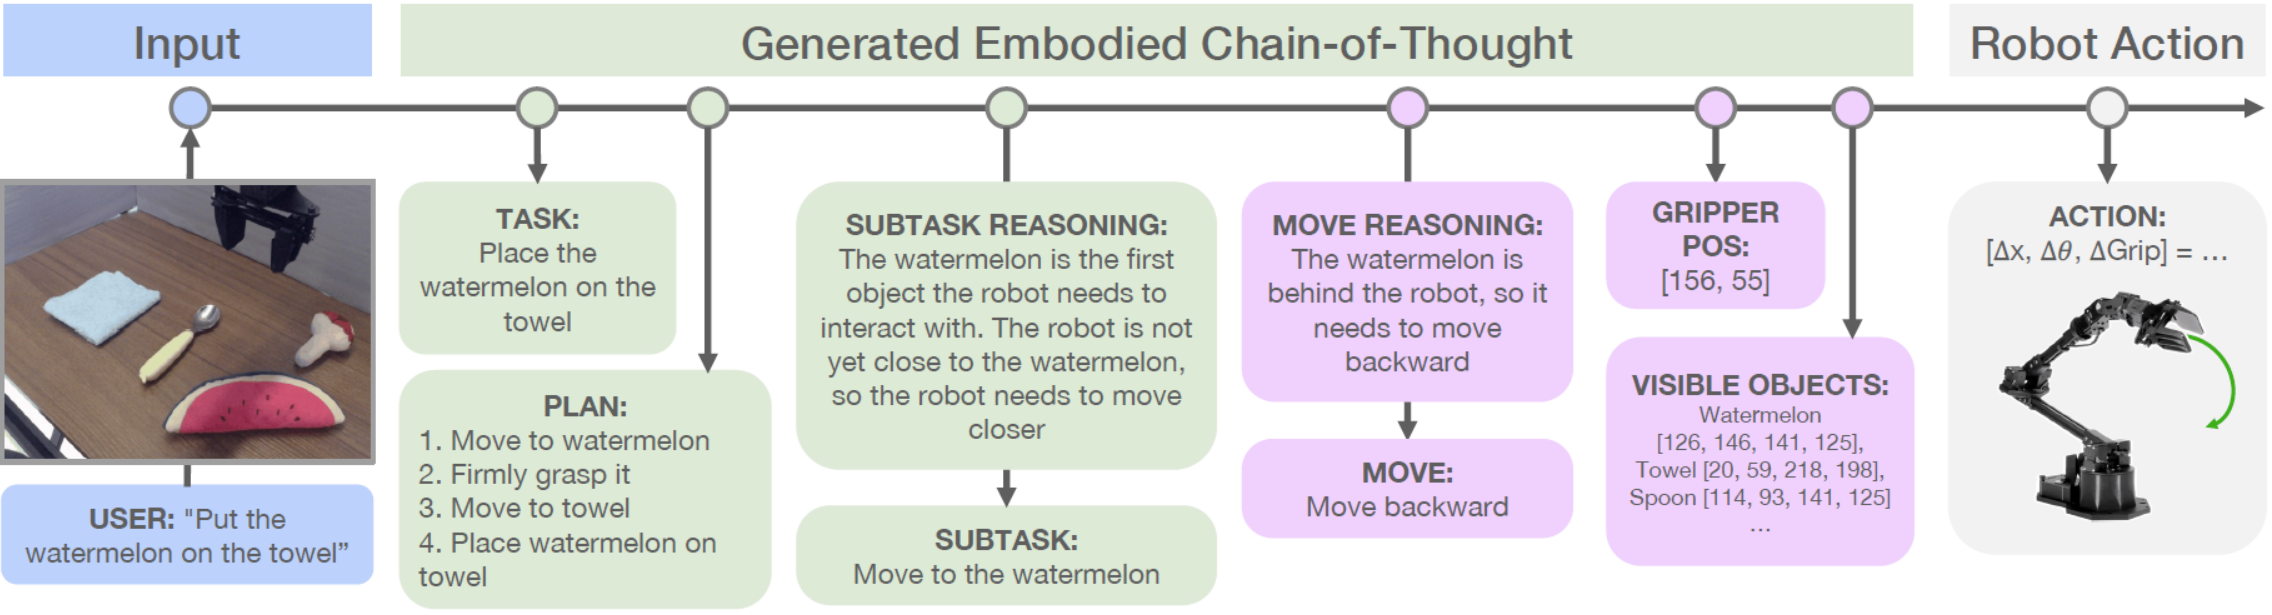
<!-- Figure 3: Steps of our embodied chain-of-thought reasoning. We interleave several intermediate reasoning steps into the mapping from inputs to robot actions. **Green**: "standard" linguistic chain-of-thought steps that break a given instruction into the required sub-tasks. **Purple**: Embodied chain-of-thought steps that require grounding the policy’s reasoning in the scene and robot state. Our experiments show that these grounded reasoning steps are key to improving policy performance with chain-of-thought reasoning. -->
图3: 我们具身思维链推理的步骤。我们将几个中间推理步骤交织到从输入到机器人动作的映射中。**绿色**: <font color="Green">"标准"语言思维链步骤, 它将给定指令分解为所需的子任务</font>。**紫色**: <font color="Purple">具身思维链步骤, 它需要将策略的推理建立在场景和机器人状态基础之上</font>。我们的实验表明, 这些有理由的推理步骤是使用思维链推理提高策略性能的关键。

## Designing Embodied Chain-of-Thought Reasoning Steps
<!-- Our goals when designing the steps of our embodied chain-of-thought reasoning chains are twofold: encourage the model to (A) reason through the required high-level steps of the task at hand and determine which step needs to be executed next, and (B) increasingly ground this reasoning in lower-level features of the scene and robot state before predicting the robot action. -->
在设计我们的具身思维链推理链的步骤时, 目标有两重: 鼓励模型 (A) 推理手头任务所需的上层步骤, 并确定接下来需要执行哪个步骤, 以及 (B) 在预测机器人动作前, 逐渐地将这种推理建立在场景和机器人状态的下层特征之上。

<!-- We visualize the ECoT reasoning steps that we train the VLA to perform for an example task in Fig. 3. From left to right, the model is trained to first rephrase the task instruction (**TASK**) and predict a high-level plan of steps for achieving the instructed task (**PLAN**). Next, it reasons through which of the sub-tasks should be executed at the present step (**SUBTASK**), a task which requires understanding the current state of the scene and robot. Then, the model predicts an even lower-level language command like "move left" or "move up" (**MOVE**) that is closely related to the low-level actions the robot needs to execute. Finally, we ask the model to predict precise, spatially grounded features that describe the scene and thus force the model to pay close attention to all elements of the input image– specifically, the pixel position of the robot end effector (**GRIPPER**) and the names and bounding box pixel coordinates of all objects in the scene (**OBJECTS**). -->
在[图3](#fig.3)中, 我们将训练 VLA 执行示例任务的 ECoT 推理步骤可视化。从左到右, <font color="red">训练模型首先重新表述任务指令 (**TASK**), 并预测上层规划的步骤, 用于实现指令任务 (**PLAN**)。接下来, 它推理当前步骤应执行哪个子任务 (**SUBTASK**), 这项任务需要了解场景和机器人的当前状态。然后, 模型预测甚至更下层的语言命令, 如"向左移动"或"向上移动"(**MOVE**), 该命令与机器人需要执行的下层动作密切相关。最后, 我们要求模型预测精确的、空间基础特征, 这些特征描述场景, 从而迫使模型密切关注输入图像的所有元素——具体而言, 机器人末端执行器 (**GRIPPER**) 的像素位置以及场景中所有物体 (**OBJECTS**) 的名称和边界框像素坐标</font>。

<!-- While we believe that our choice of reasoning tasks and their order is well-aligned with our intuition for a sensible step-by-step solution to the task, we by no means exhaustively explored all possible reasoning tasks. Testing alternative tasks and task orderings, and finding ways to automatically determine sensible reasoning chains are important directions for future work. -->
尽管我们相信, (我们对推理任务及其顺序的选择)符合(我们对合理逐步解决任务的直觉), 但我们绝不会详尽地探索所有可能的推理任务。测试替代任务和任务顺序, 以及找到自动确定合理推理链的方法, 是未来研究的重要方向。

## Generating Embodied Chain-of-Thought Data at Scale
<!-- The gold standard for obtaining high-quality reasoning chains are direct human annotations. However, this approach is impractical for large robot learning datasets [6], which consist of millions of individual transitions. Thus, we instead propose to leverage pre-trained vision and/or language foundation models to automatically generate ECoT training data, akin to synthetic data generation in NLP [63]. -->
获得高质量推理链的黄金标准是直接人工注释。然而, 这种方法对于大型机器人学习数据集 [6] 来说不切实际, 这些数据集包含数百万个单独的转换。因此, 我们提出利用预训练的视觉和/或语言基础模型, 自动生成 ECoT 训练数据, 类似于 NLP 中的合成数据生成 [63]。

<!-- We provide an overview of our data generation pipeline in [Fig. 4](#fig.4). For a given image-instruction pair, we first prompt a Prismatic-7B VLM [35] to generate a detailed description of the scene. We then concatenate the original instruction and this generated description and input the resulting string into Grounding DINO [29], an open-vocabulary object detector. It detects all relevant object instances and their bounding boxes and associates them with the corresponding language snippets from the input text. We filter the predictions based on the provided confidence score, only keeping detections with a box- and text-confidence larger than 0.3 and 0.2 respectively to use for the **OBJECT** features. See [Appendix A](#todo) for example detections. -->
我们在[图4](#fig.4)中概述了我们的数据生成。对于给定的图像-指令对, 我们首先提示 Prismatic-7B VLM [35] 生成场景的详细描述。然后, 我们将原始指令和生成的描述连接起来, 并将生成的字符串输入到 Grounding DINO [29], 一个开放词汇表对象检测器。它检测所有相关的对象实例及其边界框, 并将它们与输入文本中相应的语言片段相关联。我们基于提供的置信度分数过滤预测, 仅保留边框和文本置信度分别大于 0.3 和 0.2 的检测, 用于 **OBJECT** 特征。示例检测请参阅[附录 A](#todo)。

<!-- Next, we generate the per-step low-level action primitives in **MOVE** (e.g., "move left", "move up"). Following Belkhale et al. [64], we use the robot proprioception to determine the movement direction for the next 4 time steps (assuming a fixed camera), and translate this into one of 729 templated movement primitives (see [Appendix B](#todo) for a list of all primitives). We use OWLv2 [60] and SAM [61] to detect 2D end effector positions in the training images (**GRIPPER**) paired with 3D positions extracted from the robot state to fit a robust estimate of the projection matrix using RANSAC [65]. We then use the 2D projections of the robot end-effector position for our training. This process is repeated for each trajectory independently, eliminating the need to assume fixed camera parameters. -->
接下来, 我们在 **MOVE** (例如, "向左移动"、"向上移动")中生成每步下层动作原语。遵循 Belkhale et al. [64], 我们使用机器人本体感知, 确定接下来 4 个时间步的运动方向(假设相机固定), 并将其转换为 729 个模板化运动原语之一 (所有原语列表请参阅[附录B](#todo))。我们使用 OWLv2 [60] 和 SAM [61] 检测训练图像 (**GRIPPER**) 中的 2D 末端执行器位置, 并与从机器人状态中提取的 3D 位置配对, 以使用 RANSAC [65] 拟合投影矩阵的鲁棒估计。然后, 我们使用机器人末端执行器位置的 2D 投影进行训练。对每条轨迹独立重复此过程, 无需假设固定的相机参数。

<!-- To generate the final reasoning chain, we feed each episode’s task instruction, scene description, and per-step movement primitives into Gemini 1.0 [62] and prompt it to produce both a high-level plan of sub-tasks in accordance with the task instruction and observed movement primitives and the current sub-task for each step. We also ask it to briefly explain the primitive movement and chosen sub-task in each step, which we include in the ECoT training data. We run our data generation pipeline on the complete Bridge v2 dataset [13], with more than 2.5M transitions, over the course of 7 days. -->
为了生成最终的推理链, 我们将每个 episode 的任务指令、场景描述和每步运动原语输入到 Gemini 1.0 [62], 并提示它根据任务指令和观察到的移动原语以及每个步骤的当前子任务生成子任务的高级计划。提示它生成子任务的上层规划(根据任务指令和观察到的运动原语)和每步的当前子任务。我们还要求它简要地解释每步中的原语运动和所选子任务, 我们将其包含在 ECoT 训练数据中。我们在完整的 Bridge v2 数据集 [13] 上运行我们的数据生成流水线, 包含超过 250 万次转换, 历时 7 天。

<span id='fig.4'></span>
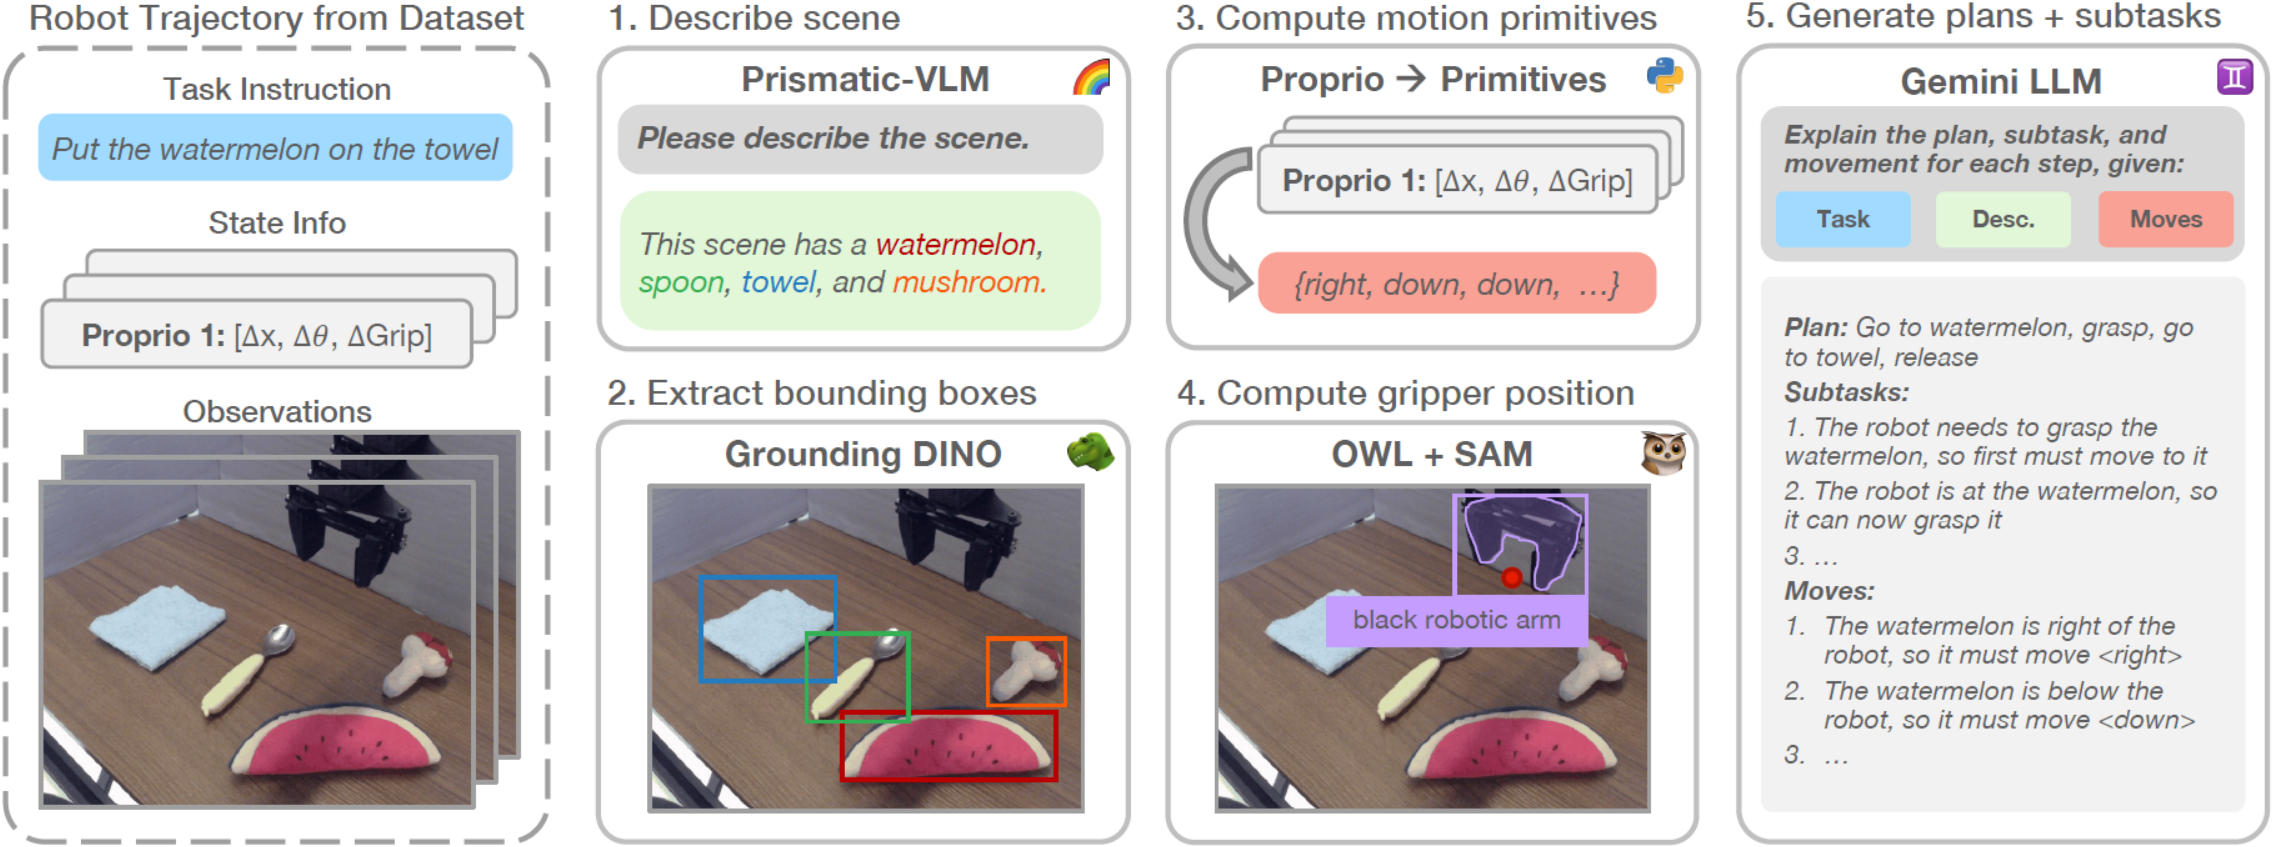
<!-- Figure 4: Our pipeline for generating synthetic embodied chain-of-thought data at scale for a given robot dataset. We use a Prismatic VLM [35] to create a scene description (1), and Grounding Dino [29] to detect bounding boxes for all objects (2). We then compute templated motion primitives from the low-level robot states (3)and the robot gripper position using OWLv2 [60] and SAM [61] (4). Finally, all information is passed to a large Gemini language model [62] to create the synthetic reasoning chain (5). -->
图4: 给定机器人数据集的大规模生成合成具身思维链数据的流水线。我们<font color="red">使用 Prismatic VLM [35] 创建场景描述 (1), 使用 Grounding Dino [29] 检测所有对象的边界框 (2)</font>。然后, 我们<font color="red">使用 OWLv2 [60] 和 SAM [61] (4), 从下层机器人状态 (3) 和机器人夹具位置, 计算模板化运动原语</font>。最后, <font color="red">所有信息都传给大型 Gemini 语言模型 [62], 创建合成推理链 (5)</font>。

## Efficient Chain-of-Thought Inference for Robot Policies
<!-- Inference speed is a key challenge for ECoT policies. The additional reasoning tokens the model needs to predict can significantly reduce the achievable control frequency by increasing the number of tokens to be predicted per timestep from 7 for OpenVLA to 350 for ECoT. We explore a simple solution for speeding up inference: we keep parts of the reasoning chain like the high-level plan or the current sub-task fixed for multiple steps. Crucially, *encoding* previously predicted tokens is much faster for Transformer-based policies like OpenVLA than *generating* it. We compare two such strategies: (1) *synchronous* execution, where we predict the high-level reasoning every $N$ steps, and (2) *asynchronous* execution, in which one ECoT policy instance continually updates the high-level reasoning chains, while a second policy instance uses the most recent reasoning chain to predict low-level reasoning steps and robot actions. We report the trade-off between performance and inference speed for all approaches in Section [5.5](#Efficient-Chain-of-Thought-Inference). Note that these runtime improvements are orthogonal to widely used approaches for improving throughput of large language and vision-language models, like optimized computation kernels [66] and speculative decoding [67], which we leave for future works. -->
推理速度是 ECoT 策略的一个关键挑战。<font color="red">(模型需要用于预测的)额外推理词元可以通过将(每个时间步要预测的)词元数量从 OpenVLA 的 7 个增加到 ECoT 的 350 个, 显著降低可实现的控制频率</font>。我们探索了一种加速推理的简单解决方案: 我们保持推理链的部分(例如上层规划或当前子任务)在多个步骤中固定。至关重要的是, 对于基于 Transformer 的策略(如 OpenVLA), *编码*先前预测的词元比*生成*它更快。我们比较了两种这样的策略: (1) *同步*执行, 其中我们每 $N$ 步预测一次上层推理, (2) *异步*执行, 其中一个 ECoT 策略实例不断更新上层推理链, 同时第二个策略实例使用最新的推理链, 预测下层推理步骤和机器人动作。我们在第 [5.5](#Efficient-Chain-of-Thought-Inference) 节中报告了所有方法的性能和推理速度之间的权衡。请注意，这些运行改进正交于广泛使用的提高大语言和视觉语言模型的吞吐量的方法, 例如优化的计算内核 [66] 和 speculative 解码 [67], 我们将这些方法留给未来的工作。

# Experiments
<!-- In this section, we investigate the effectiveness of ECoT for robot control across a range of challenging manipulation tasks. We answer the following questions: (1) Does embodied chain-of-thought reasoning improve the performance of VLA policies (Section [5.2](#Embodied-Chain-of-Thought-Reasoning-Improves-Policy-Generalization))? (2) Does embodied chain-of-thought reasoning make it easier to interpret and correct policy failures (Sections [5.3](#Diagnosing-Policy-Failures-Through-Inspecting-Reasoning-Chains) and [5.4](#Chain-of-Thought-Reasoning-Enables-Interactive-Policy-Correction))? (3) How can we optimize the runtime efficiency of policies with embodied CoT reasoning (Section [5.5](#Efficient-Chain-of-Thought-Inference))? -->
在本节中, 我们在一系列具有挑战性的操作任务中, 研究了 ECoT 对机器人控制的有效性。我们回答下列问题: (1) 具身思维链推理能否提高 VLA 策略的性能 (第 [5.2](#Embodied-Chain-of-Thought-Reasoning-Improves-Policy-Generalization) 节)? (2) 具身思维链推理能否使解释和修正策略失败变得更容易 (第 [5.3](#Diagnosing-Policy-Failures-Through-Inspecting-Reasoning-Chains) 和 [5.4](#Chain-of-Thought-Reasoning-Enables-Interactive-Policy-Correction) 节)? (3) 如何使用具身 CoT 推理, 优化策略的运行效率 (第 [5.5](#Efficient-Chain-of-Thought-Inference) 节)?

## Experimental Setup
<!-- **Robot setup and training data**. We perform evaluations with the 6-DoF WidowX robot arm from the Bridge V2 paper [13], a commonly used setup for evaluating generalizable robot policies [16, 7]. Given a single $3^{rd}$ person camera and natural language instruction, the policy predicts end-effector velocity actions to control the robot. Walke et al. [13] provide a large and diverse teleoperated dataset of 60k demonstrations. We apply our pipeline for synthetic generation of chain-of-thought data (Section [4.2](#Generating-Embodied-Chain-of-Thought-Data-at-Scale)) on this dataset to obtain our training dataset. -->
**机器人配置和训练数据**. 我们使用 Bridge V2 论文 [13] 中的 6-DoF WidowX 机械臂进行评估, 一种用于评估通用机器人策略的常用配置 [16, 7]。给定一个第三人称相机和自然语言指令, 该策略预测末端执行器速度动作以控制机器人。Walke et al. [13] 提供了一个包含 60k 演示的大型多样化远程操作的数据集。我们在此数据集上采用我们的思路链数据合成生成流水线(第 [4.2](#Generating-Embodied-Chain-of-Thought-Data-at-Scale) 节), 以获得我们的训练数据集。

<!-- **Evaluation tasks**. We design a suite of challenging evaluation tasks that focus on testing the policies’ generalization ability along multiple axes: processing spatial relations, interacting with unseen objects, and performing unseen instructions. All policies are evaluated on the same real-world setups to control for camera angle, lighting, and background. We perform 314 total trials per approach. -->
**评估任务**. 我们设计了一套具有挑战性的评估任务, 这些任务聚焦于测试策略在多个维度的泛化能力: 处理空间关系、与未见过的物体交互, 以及执行未见过的指令。所有策略都在相同的真实世界配置上进行评估, 以控制摄像头角度、照明和背景。我们对每种方法总共执行 314 次试验。

**Comparisons**. We compare our policy (**ECoT**) to state-of-the-art VLA policies, namely **Open-VLA** [7], the same model our approach is built upon, but trained *without* chain-of-thought reasoning, and **RT-2-X** [6], a 55B parameter closed VLA policy. To ensure fair comparison, we train the Open-VLA policy on the same dataset we use for training our approach (the Bridge V2 data [13]). Said policy is thus denoted as **OpenVLA (Bridge)**. For RT-2-X we cannot control the data distribution in the same way since the model is closed. The RT-2-X policy we compare to was trained on Bridge V2 data *and additional datasets from the Open X-Embodiment dataset* [6]. Thus, it has access to *more* training data than our approach. We also compare against **Octo** [16], which is also trained on that dataset, but was not fine-tuned from a VLM (i.e., it is not a VLA). Finally, we compare to **Naïve CoT**, a version of our model that only uses *non-embodied* CoT reasoning about sub-tasks akin to conventional CoT reasoning in language modeling (see [Fig. 3](#fig.3)). This comparison will test the importance of using *embodied* reasoning for VLA policies.
**比较**. 我们将我们的策略 (**ECoT**) 与最先进的 VLA 策略 (即 **Open-VLA** [7], 与我们的方法所基于的模型相同, 但"没有使用"思路推理进行训练) 和 **RT-2-X** [6] (一个 55B 参数闭源的 VLA 策略) 进行比较。为了确保公平比较, 我们在训练我们方法所用的相同数据集 (Bridge V2 数据 [13]) 上训练 Open-VLA 策略。因此, 该策略表示为 **OpenVLA (Bridge)**。对于 RT-2-X, 由于模型是闭源的, 我们无法以相同的方式控制数据分布。我们所比较的 RT-2-X 策略是在 Bridge V2 数据*和来自 Open X-Embodiment dataset 的额外数据集* [6] 上训练的。因此, 它可以访问比我们方法*更多*的训练数据。我们还与 **Octo** [16] 进行了比较, 它也在该数据集上进行训练, 但未从一个 VLM 进行微调(即它不是一个 VLA)。

最后，我们与 **Na$\ddot{i}$ve CoT** 进行了比较，这是我们模型的一个版本，它仅使用类似于语言建模中传统 CoT 推理的 *非具象* CoT 推理来处理子任务（参见 [图 3](#fig.3)）。

此比较将测试使用 *具象* 推理对 VLA 策略的重要性。


## Embodied Chain-of-Thought Reasoning Improves Policy Generalization
We report performance of all approaches on our evaluation set in [Table 1](#table.1). We see that while OpenVLA (Bridge) achieves high performance on in-distribution tasks, it struggles on the hard generalization cases we test. RT-2-X performs better than vanilla OpenVLA (Bridge), potentially due to the larger robot pre-training dataset (note again that OpenVLA and our approach are *only* trained on the Bridge dataset) and the fact that it *co-trains* the policy with Internet-scale vision-language data androbot data, while all other approaches only use robot data during fine-tuning.


todo: 表1
Table 1: **Comparison of success rates for OpenVLA, RT-2-X, and ECoT** across two scenes (one with in-distribution camera view and one with out-of-distribution). Mean ±one StdErr. On aggregate, our ECoT policy achieves the highest success rate, improving absolute success rate by 45%, 22%, 19%, and 18% over Octo, OpenVLA, RT-2-X, and naïve CoT respectively in the in-distribution view setting and 48%, 34%, 16%, and 16% in the out-of-distribution view setting.


Importantly, we find that our ECoT policy substantially outperforms the OpenVLA (Bridge) policy across all generalization evaluations but one. This is notable, since both policies are based on the exact same VLM base model and use the same robot data for fine-tuning. The only difference is in the use of CoT reasoning by our approach. Curiously, our ECoT model even surpasses the performance of RT-2-X in the tested tasks, even though RT-2-X is trained on 10 additional robot datasets and uses a neural network that is 7x larger (55B vs. 7B). Finally, the results in Table 1 show that including *embodied* reasoning about visual inputs and the low-level robot state significantly boosts performance over the "Naïve CoT" ablation of our approach, which only reasons about high-level linguistic features like sub-task plans.


We visualize qualitative examples of our model's reasoning in [Fig. 5](#fig.5). The left two examples show that the model successfully breaks down the task into a sequence of sub-tasks and then crucially *grounds* those sub-tasks in the scene by predicting the relevant bounding boxes and gripper position of the robot, before deciding on the next move and concrete low-level robot action. We visualize more chain-of-thought examples from our evaluation tasks in [Fig. 9](#fig.9).


todo: 图5
Figure 5: **Qualitative ECoT predictions from our model for two successful trajectories (left, middle) and one failure (right)**. Irrelevant bounding boxes are greyed out for readability. Left: high-level reasoning and low-level object segmentations are correct, leading to a successful rollout. Middle: the command is correctly rephrased to refer to specific objects (i.e., “the leftmost object” is identified as the pink toy). Right: the hammer is incorrectly identified as a screwdriver, causing the robot to take inappropriate actions.

todo: 图9

## Diagnosing Policy Failures Through Inspecting Reasoning Chains
In the previous section we showed that training VLA policies to reason through a given task step-by-step can significantly improve their performance on challenging generalization tasks. In addition to improving performance, such chain-of-thought reasoning provides a tool for users and researchers to better understand the decisions the policy takes. By inspecting and visualizing the model’s reasoning steps, we can discover potential mistakes in the reasoning chain that led to policy failure downstream.


We give an example of this in [Fig. 5](#fig.5) (right): the ECoT policy failed to solve the task *pick up the screwdriver*. Inspecting the reasoning chain, we can see that the hammer is incorrectly identified as a screwdriver, causing the robot to reach for that instead. It should be noted that such inspection of reasoning chains is not a "bullet-proof" approach for interpreting the failures of an end-to-end trained policy: the model *could* predict a particular plan and then still deviate from it when choosing the final action. However, in practice we find that reasoning chains often correlate strongly with the executed actions. We provide more examples for diagnosing policy failures via its reasoning chains in [Fig. 9](#fig.9).


## Chain-of-Thought Reasoning Enables Interactive Policy Correction
Intuitively, training a policy to reason through a task step-by-step in natural language provides a powerful mechanism for humans to interact with the policy and *correct* its behavior. Instead of needing involved teleoperation equipment to provide direct robot action feedback like in DAgger approaches [68], humans can now simply correct the policy’s behavior by modifying its reasoning chains via natural language feedback. Prior work introduced carefully designed policy architectures and explicitly trained policies to support such correction via language [69, 70]. Here, we test whether similar capabilities emerge naturally by training VLA policies to perform chain-of-thought reasoning.


To test whether chain-of-thought policies enable human correction purely via language feedback, we
rerun evaluations of our ECoT policy on the most challenging tasks from [Table 1](#table.1) (put mushroom in
cup, pick up out-of-distribution object, and pick up non-yellow object), in which our policy *without
human intervention* achieved an average success rate of only 32%. We visualize our approach for
human intervention in [Fig. 6](#fig.6): we allow a human operator to interrupt policy execution *once* over the
course of the episode and provide natural language feedback (e.g. "no, the screwdriver is in the back
right corner", "release the mushroom now!", or "the cup is tall"). Then, we use ChatGPT to adapt
our model’s reasoning chain based on the language feedback, prompting it to produce a corrected
reasoning chain (see [Fig. 12](#fig.12) for the exact prompt used). Finally, we feed this corrected chain back
into our policy and continue execution, holding the corrected reasoning chain fixed for 5 steps.


todo: 图6
Figure 6: Embodied chain-of-thought training enables interactive human policy correction in natural language. **Left**: given a human intervention in natural language, we use ChatGPT to correct our model’s reasoning chains. **Right**: our embodied chain-of-thought policy can benefit from a human language intervention most, increasing success rate by 48% on our most challenging evaluation tasks.


The results in [Fig. 6](#fig.6) (right) show that our ECoT policy can make effective use of the human language
intervention, increasing its success rate by 48% on our most challenging evaluation tasks. In contrast,
we evaluate the vanilla, non-CoT OpenVLA policy and RT-2-X in the same way, providing each with
a single human language correction per rollout, but find that neither of them can benefit from the
human intervention to the same degree (for both we also use ChatGPT to incorporate the intervention
into the original task instruction to allow for fair comparison).

In [6]:
from pypdf import PdfReader

# pdf_path = "/mnt/d/cfz/github/Robotic Control via Embodied Chain-of-Thought Reasoning.pdf"
pdf_path = "/mnt/d/github/paper/具身机器人/Robotic Control via Embodied Chain-of-Thought Reasoning.pdf"

reader = PdfReader(pdf_path)
number_of_pages = len(reader.pages)
page = reader.pages[7]
text = page.extract_text()
print(text)

TASK:Pick up the screwdriverand move it to the containerPLAN:Move to the screwdriver, pick it up, and move it to the containerSUBTASK:The screwdriveris in the top-left corner, so the robot needs to move forward and down to reach it àMove to the screwdriverMOVE:The robot has reached the screwdriveràStopTASK:Move the mushroomto the detergentPLAN:Move to the mushroom, grasp it, move to the detergent, release the mushroomSUBTASK:The mushroomis the closest object to the robot, and needs to be grasped first àMove to the mushroomMOVE:The mushroomis to the right of the robot, so the robot needs to move right àMove right“Move the mushroom to the detergent”“Put the leftmost object on the middle object”“Pick up the screwdriver”
a white mushrooma blue plastic bottle of detergent
a red screwdriver
a blue towela pink stuffed animal
TASK:Put the pink stuffed animalon the blue towelPLAN:Move to the pink stuffed animal. Pick up the pink stuffed animal. Move to the blue towel. Put the pink stuffed anima